<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/2_Cross_Sectional_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Sectional Momentum

In this notebook we do factor analysis on simple momentum factors.

We find a strong, persistent and robust cross-sectional momentum effect.

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'RcppRoll', 'QuantTools'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



-- R CMD build -----------------------------------------------------------------
* checking for file /tmp/Rtmpw8EK8y/remotes895f25151b/RWLab-rwRtools-1924b0b/DESCRIPTION ... OK
* preparing rwRtools:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted LazyData from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    rwRtools/R/sysdata.rda
* building rwRtools_0.1.33.tar.gz



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coinmetrics daily data

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>% 
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


i Downloading coinmetrics.csv

v Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Creating research universe

See Notebook 1 for details on how we construct the universe.

In [4]:
# snippet: rw crypto flag universe consituents v0.1
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= '2015-04-01') %>%
    na.omit() %>%
    ungroup()
}

In [5]:
universe <- create_universe(prices, n = 10, min_constituents = 10)
universe %>%
  head()

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-18,0.08584000,295959.2,1,FALSE
BTC,2010-07-19,0.08080000,279285.2,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,1,FALSE


In [6]:
universe%>%
head()

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-18,0.08584000,295959.2,1,FALSE
BTC,2010-07-19,0.08080000,279285.2,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,1,FALSE


# Create Momentum Feature and Forward Returns

Calculate 20 day momentum factor and next day returns.

In [7]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(momo20 = price_usd / lag(price_usd, n = 20) - 1,
         lagmomo20 = lag(momo20)) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-08-08,0.06090000,222623.0,1,FALSE,-0.24628713,-0.31262879,0.144960088,0.155993432
BTC,2010-08-09,0.07040000,258019.5,1,FALSE,-0.05801414,-0.24628713,-0.015189656,-0.015074875
BTC,2010-08-10,0.06933873,254792.1,1,FALSE,-0.12443210,-0.05801414,-0.034310988,-0.033729041
BTC,2010-08-11,0.06700000,246978.8,1,FALSE,0.14589148,-0.12443210,0.043802623,0.044776119
BTC,2010-08-12,0.07000000,258797.0,1,FALSE,0.15525144,0.14589148,-0.081830018,-0.078571429
BTC,2010-08-13,0.06450000,239156.3,1,FALSE,0.18261826,0.15525144,0.037974165,0.038704398
BTC,2010-08-14,0.06699643,249354.0,1,FALSE,0.32559584,0.18261826,-0.028439422,-0.028038828
BTC,2010-08-15,0.06511793,243036.4,1,FALSE,0.16282022,0.32559584,0.005850175,0.005867321
BTC,2010-08-16,0.06550000,244943.8,1,FALSE,0.11732765,0.16282022,0.066445099,0.068702290


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum 
 - Group by rank
 - Plot the mean next day log return for each rank. 

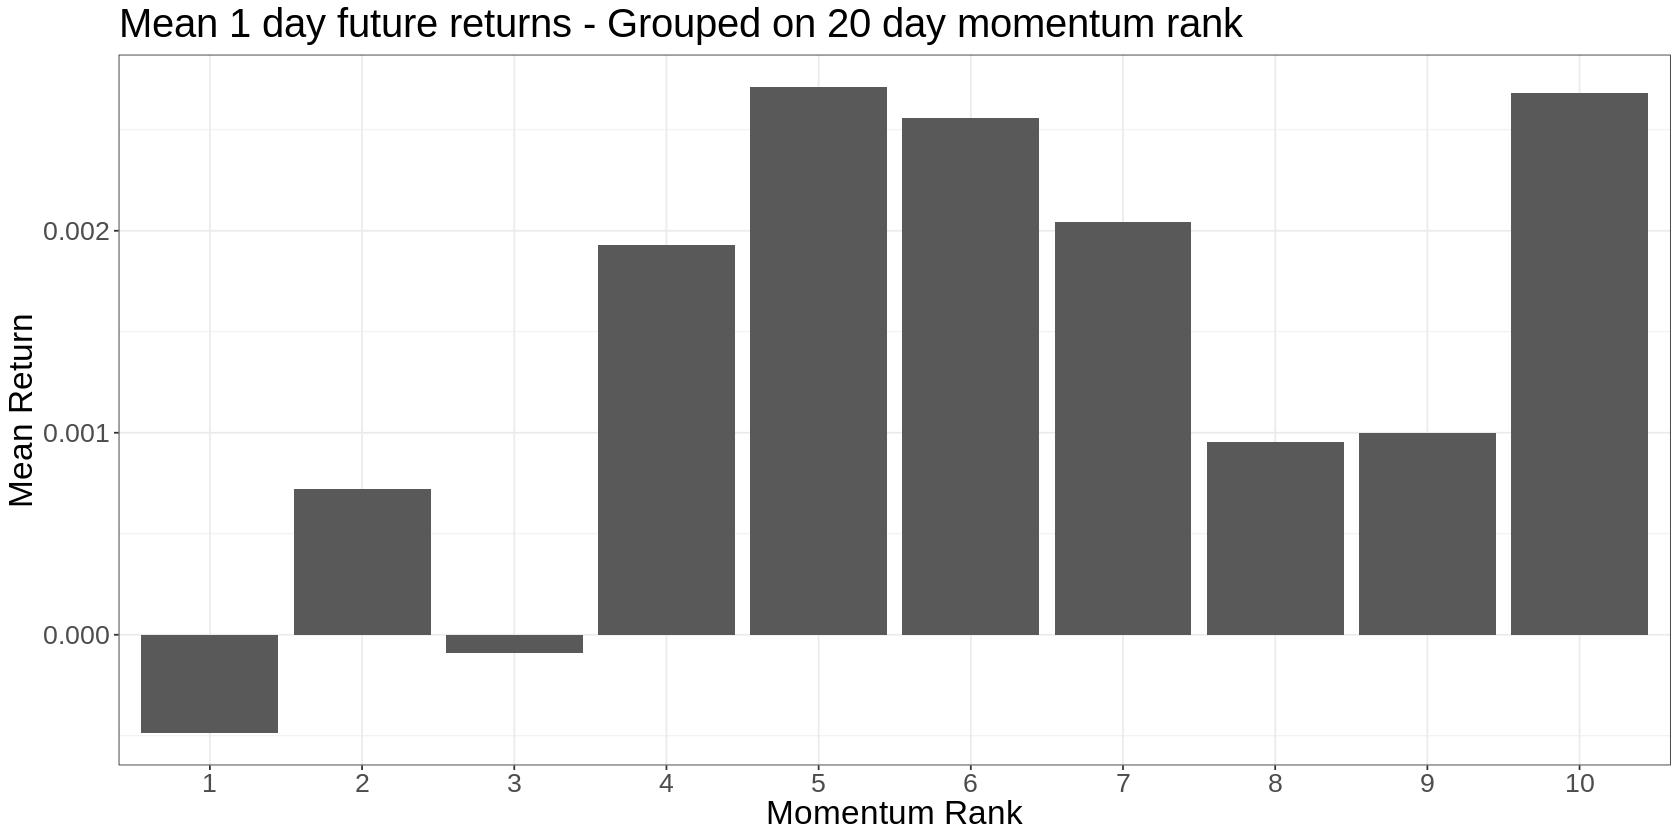

In [8]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


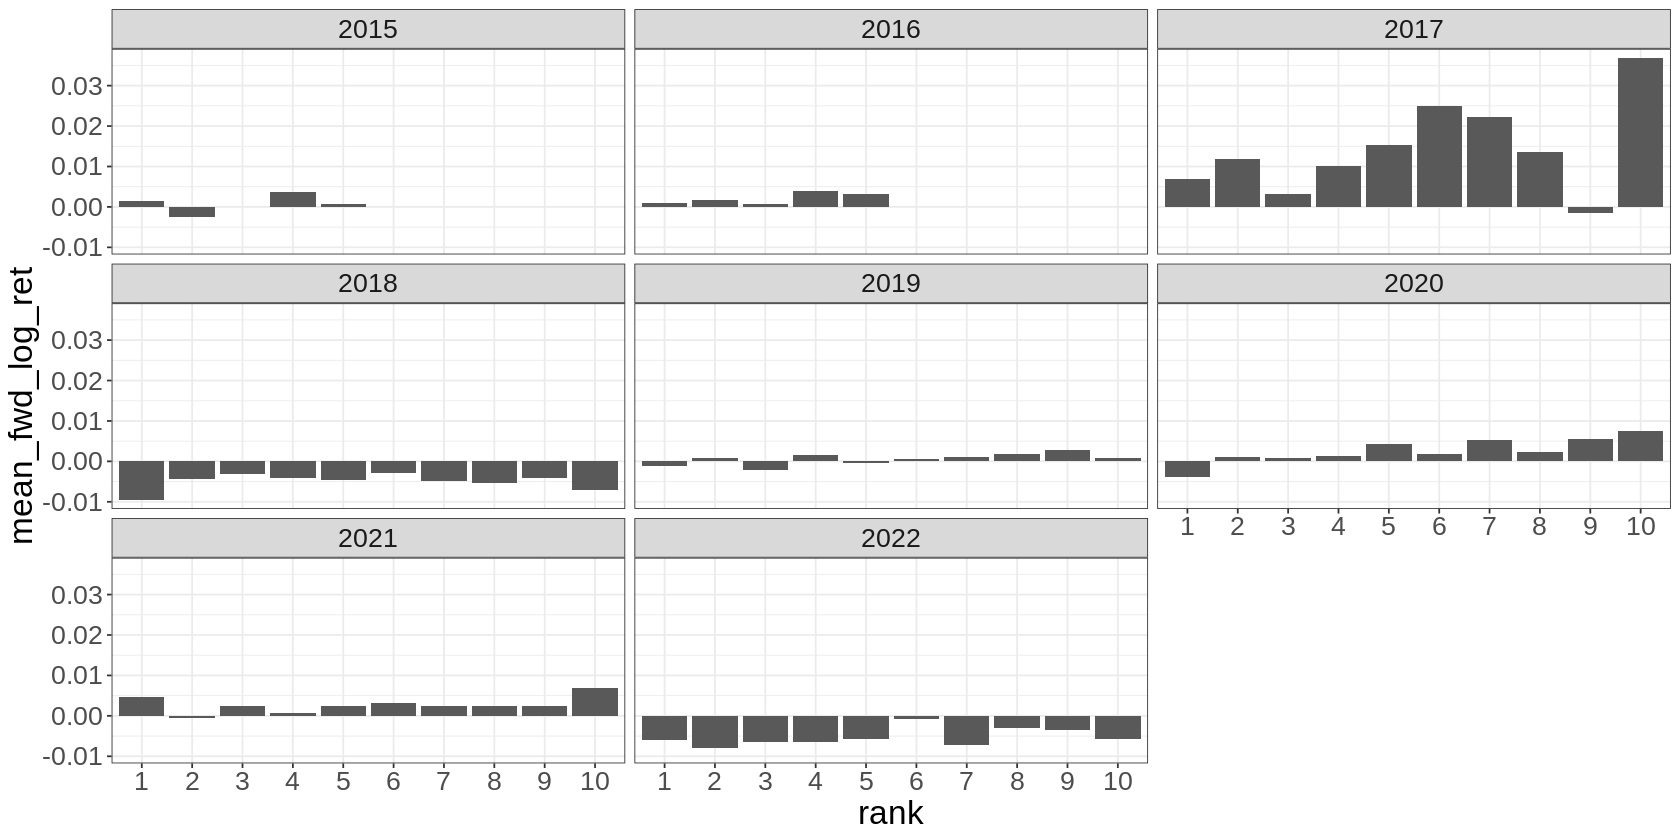

In [9]:
returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

To make this easier to interpret, let's demean our return target - so we're plotting the relative outperformance rather than absolute outperformance.

In [10]:
demeaned_returns <- returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    demeaned_fwd_log_return = fwd_log_return - mean(fwd_log_return),
    demeaned_fwd_simple_return = fwd_simple_return - mean(fwd_simple_return) 
  )

demeaned_returns %>% tail(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return,demeaned_fwd_log_return,demeaned_fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2022-05-31,3.183141e+04,606539699591,1,TRUE,0.10538943,0.02404654,-0.0650756354,-0.0630034094,0.001661200,0.001217863
CRO,2022-05-31,1.896098e-01,18960975299,4,TRUE,-0.01986923,-0.17519359,-0.0596887850,-0.0579423296,0.007048051,0.006278943
DOGE,2022-05-31,8.607264e-02,11589631938,5,TRUE,0.02436267,-0.18912530,-0.0601680218,-0.0583936901,0.006568814,0.005827583
ETH,2022-05-31,1.947317e+03,230989617649,2,TRUE,-0.05848263,-0.14786122,-0.0634286115,-0.0614588821,0.003308224,0.002762391
FTT,2022-05-31,2.901579e+01,9630785202,6,TRUE,-0.01654068,-0.11800290,-0.0744831479,-0.0717768835,-0.007746312,-0.007555611
LINK,2022-05-31,7.637923e+00,7637922918,8,TRUE,0.10876964,-0.13072471,-0.0976540931,-0.0930374259,-0.030917257,-0.028816153
LTC,2022-05-31,6.865651e+01,4833979040,10,TRUE,0.03799432,-0.13743462,-0.0876535369,-0.0839217910,-0.020916701,-0.019700518
TRX,2022-05-31,8.350335e-02,8350335492,7,TRUE,0.12397863,0.08580619,0.0001517352,0.0001517467,0.066888571,0.064373020
UNI,2022-05-31,5.707797e+00,5707796751,9,TRUE,0.17673422,-0.06950393,-0.0992629487,-0.0944954245,-0.032526113,-0.030274152


If we've done this right, then the sum of the demeaned returns for all dates should be zero.

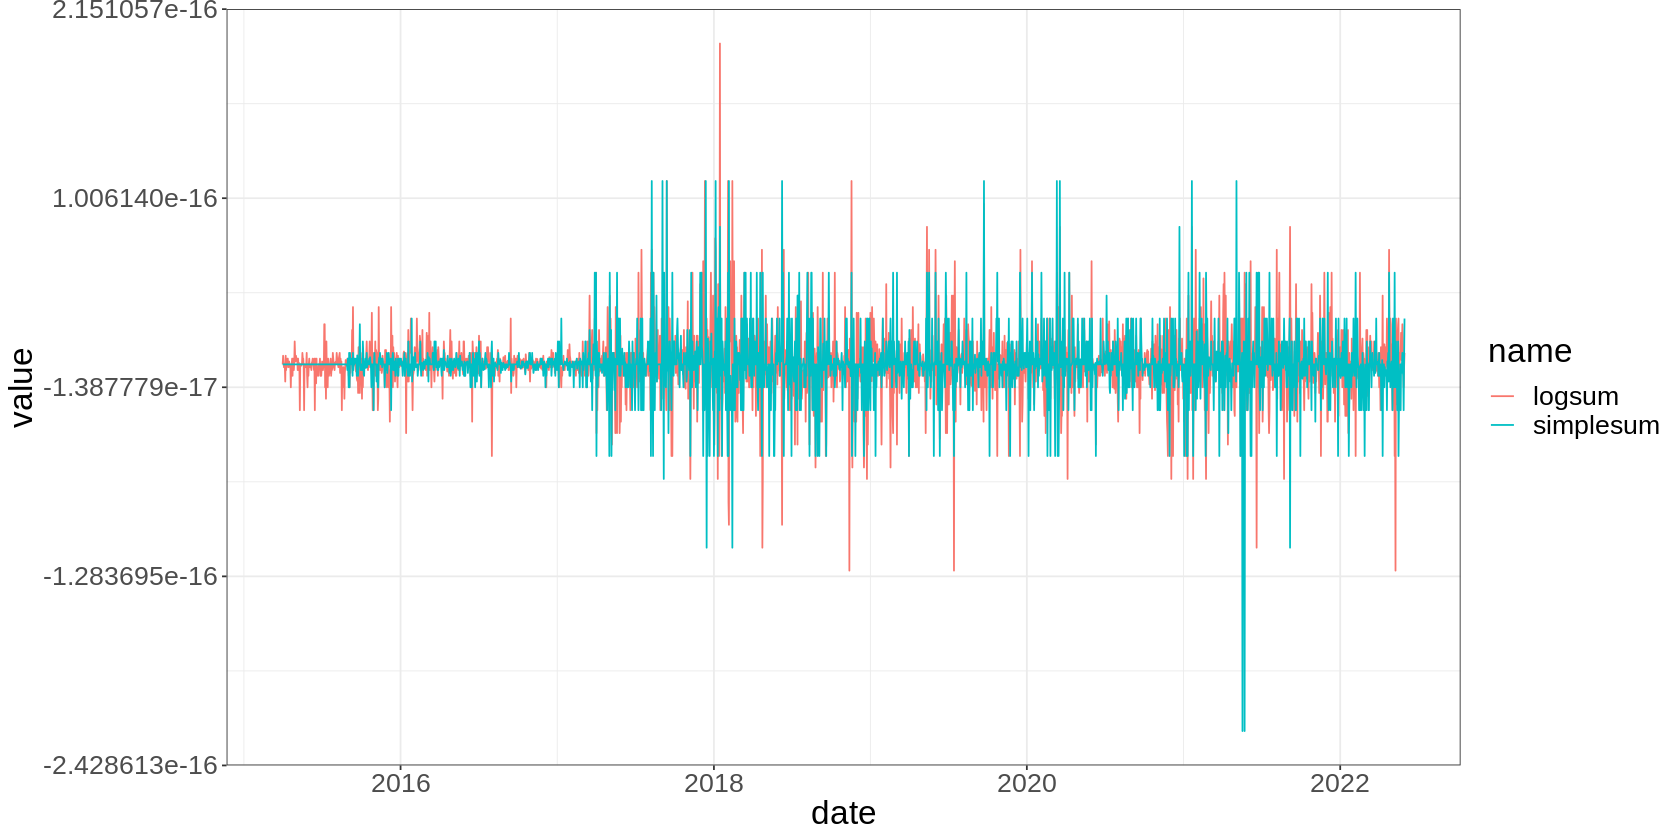

In [11]:
demeaned_returns %>%
  group_by(date) %>%
  summarise(
    logsum = sum(demeaned_fwd_log_return),
    simplesum = sum(demeaned_fwd_simple_return)
  ) %>%
  pivot_longer(-date) %>%
  ggplot(aes(x=date, y=value, color = name)) + geom_line()

Just rounding stuff...

Now let's plot de-meaned log return for each rank for each year

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


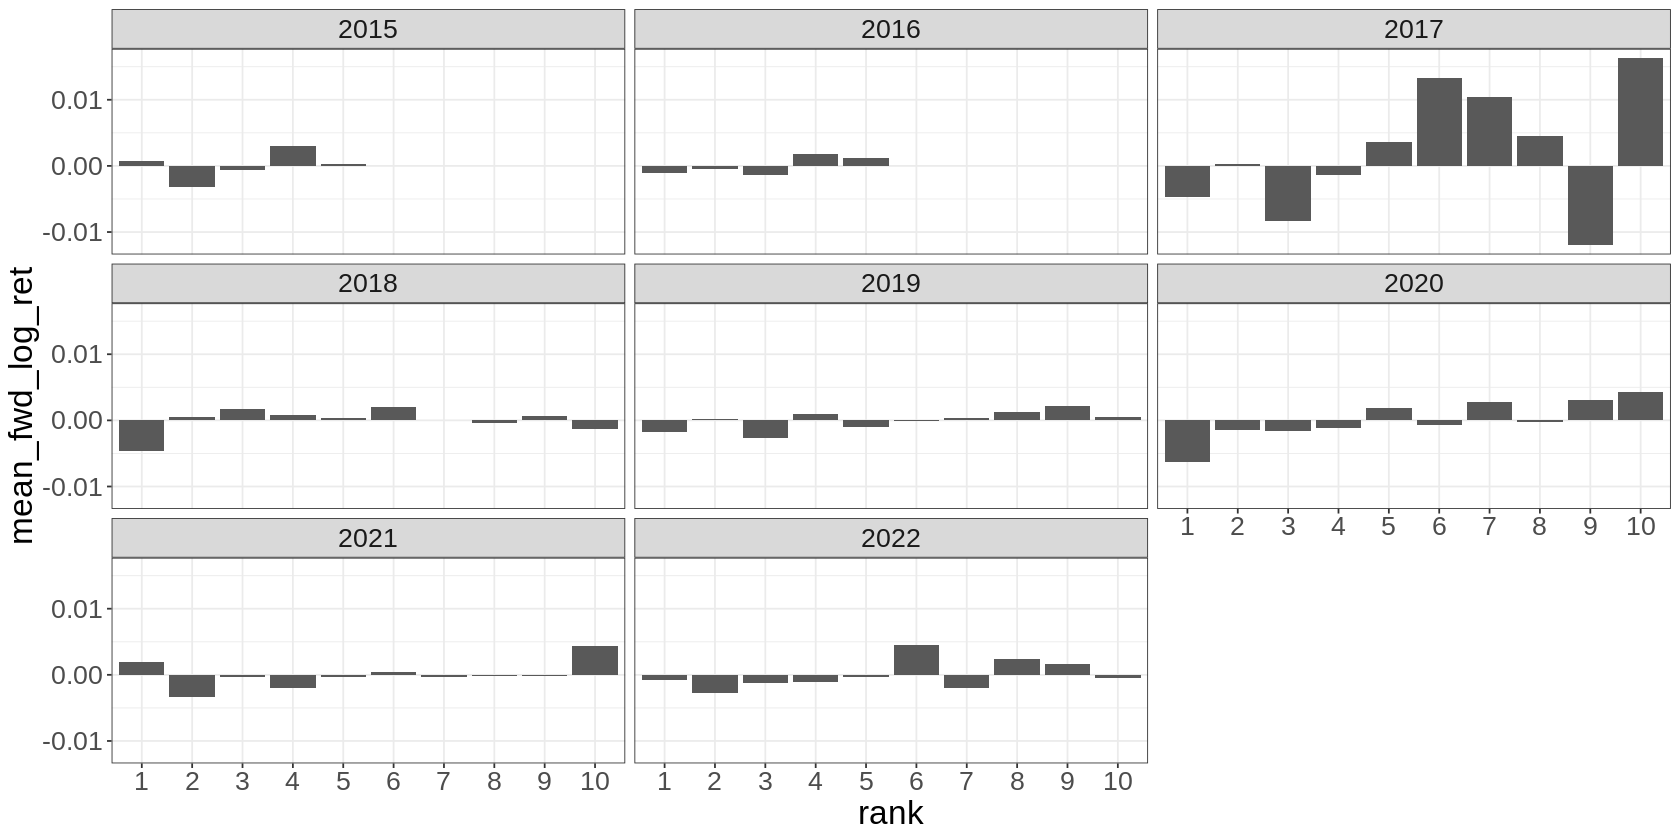

In [12]:
demeaned_returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

Daily momentum / reversal effects are a thing. I want to put a day in between our feature and target and see if it impacts anything.

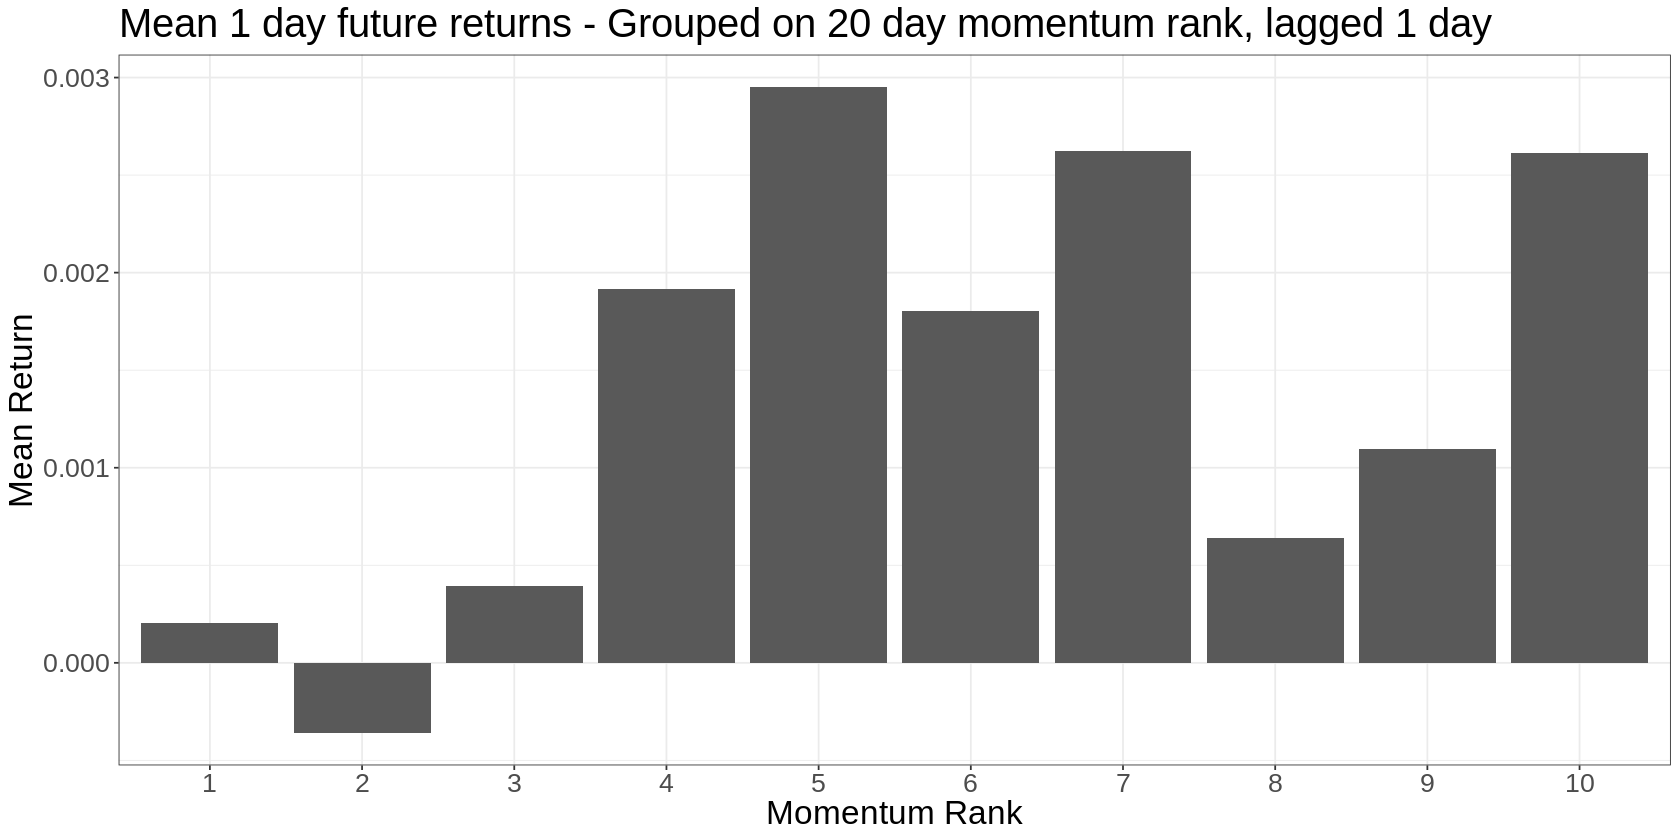

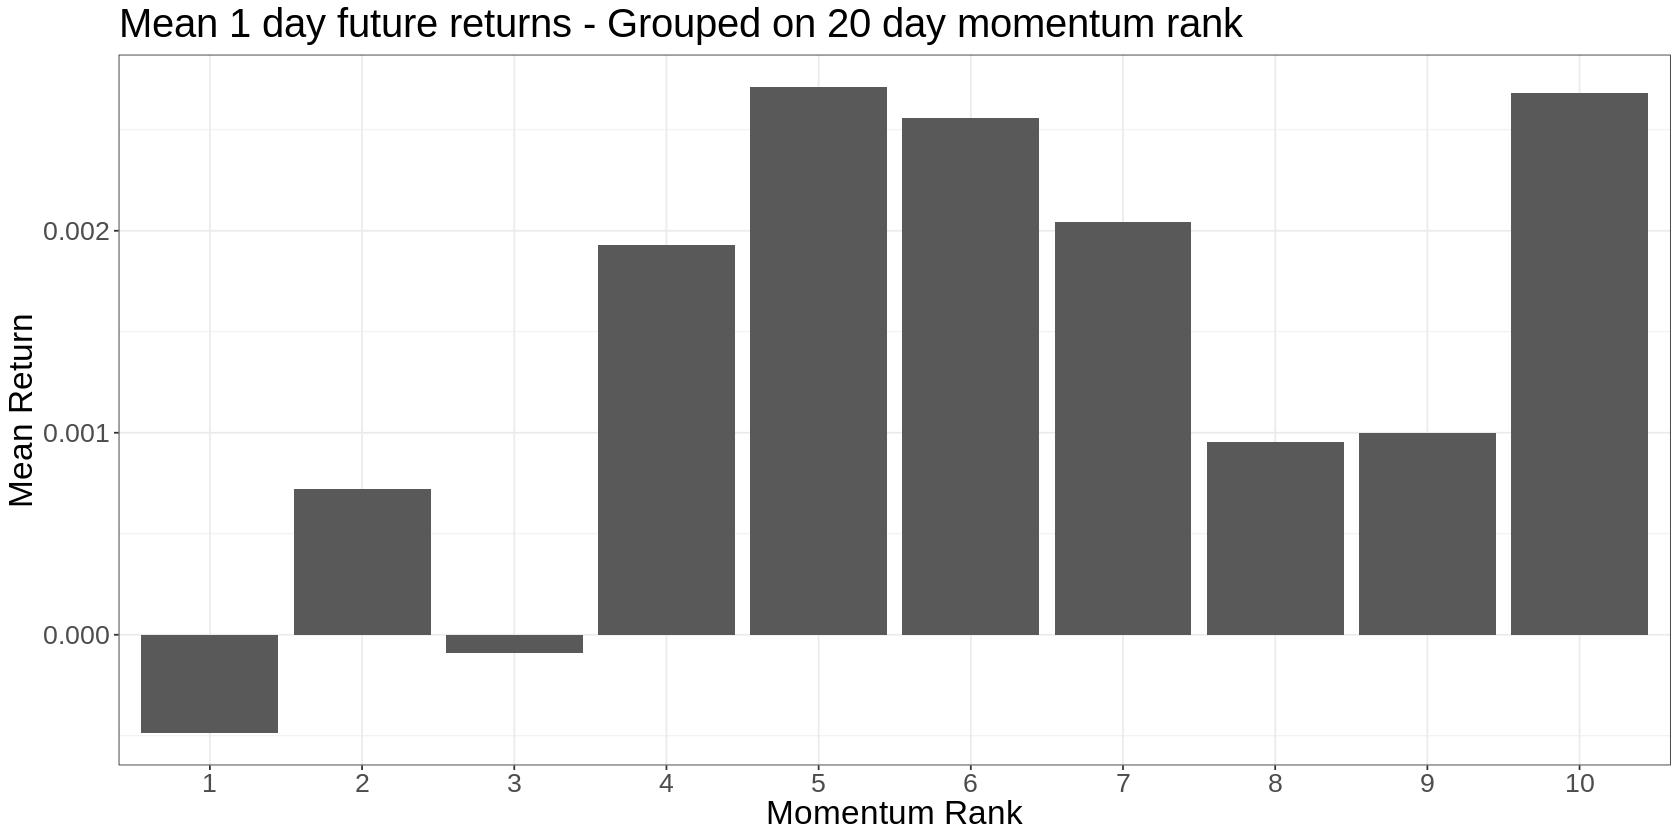

In [13]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(lagrank = factor(row_number(lagmomo20))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank, lagged 1 day',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

  returns %>%
    filter(is_index == TRUE) %>%
    group_by(date) %>%
    mutate(rank = factor(row_number(momo20))) %>%
    group_by(rank) %>%
    summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
    ggplot(aes(x=rank, y=mean_fwd_log_ret)) + 
    geom_bar(stat='identity') + 
    labs(
      title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
      x = 'Momentum Rank',
      y = 'Mean Return'
    )

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


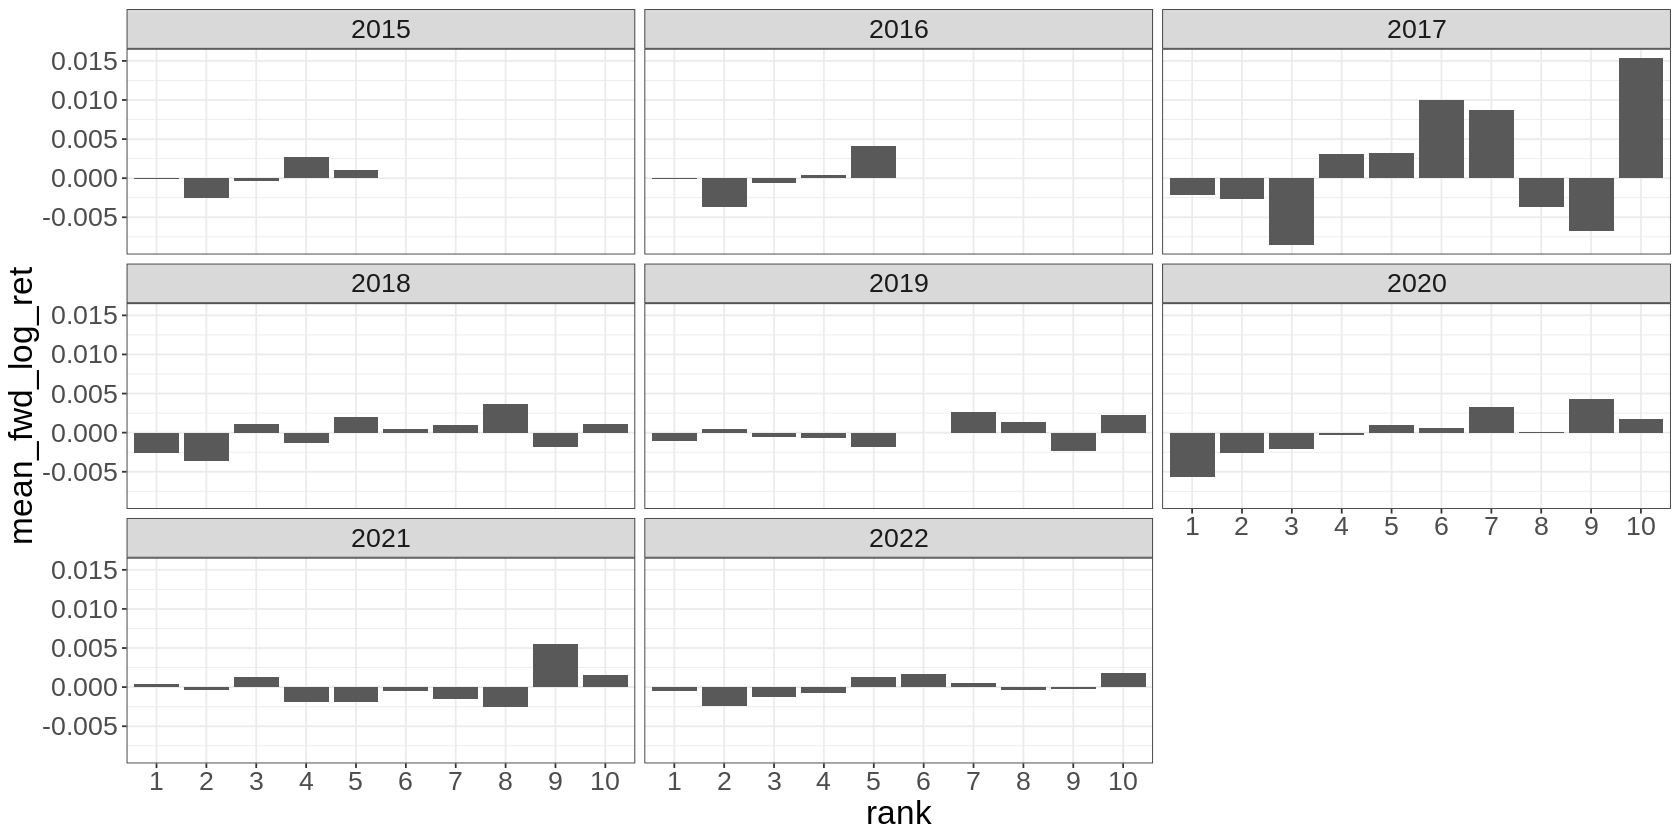

In [14]:
demeaned_returns %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(lagmomo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

# Creating a factor time series

Now, we're going to construct a number of factor time series. 

1. Top decile - bottom decile
2. Weight all assets in proportion to rank - mean(rank)
3. Weight all assets in proportion to zscore


## 1: Top - Bottom Decile Factor Plot

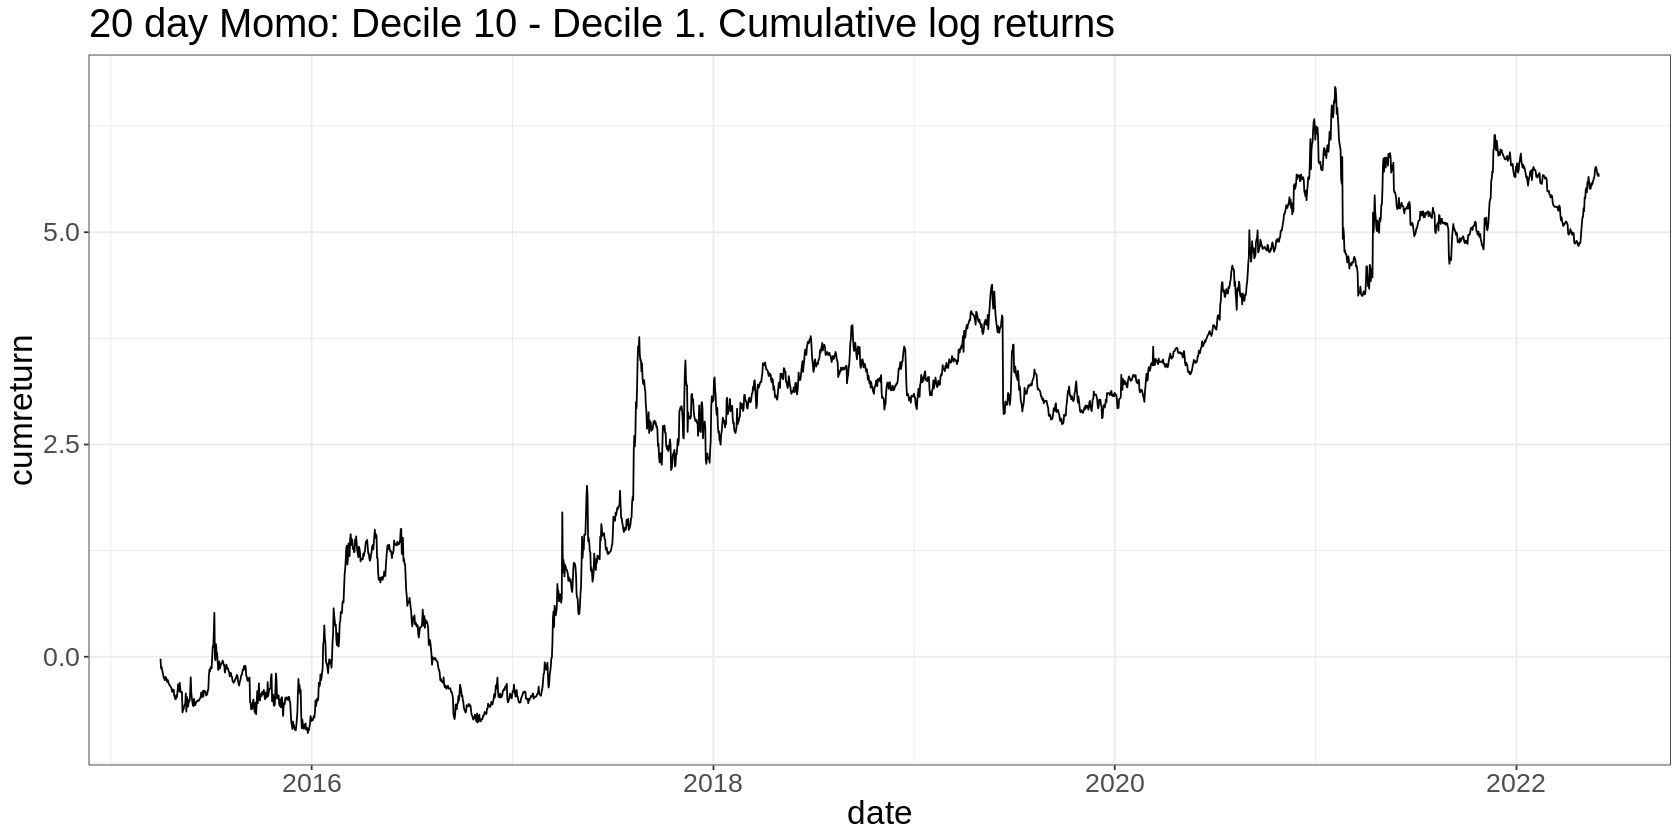

In [15]:
top_ranked <- returns %>% 
  filter(is_index) %>%
  group_by(date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == max(rank)) %>%
  select(date, top_return = fwd_simple_return)

bottom_ranked <- returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == min(rank)) %>%
  select(date, bottom_return = fwd_simple_return)

top_ranked %>%
  inner_join(bottom_ranked, by = 'date') %>%
  mutate(
    factor_return = top_return - bottom_return,
    log_factor_return = log(1+factor_return)
  ) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Decile 10 - Decile 1. Cumulative log returns')



##2: Weight all assets in proportion to rank - mean(rank)

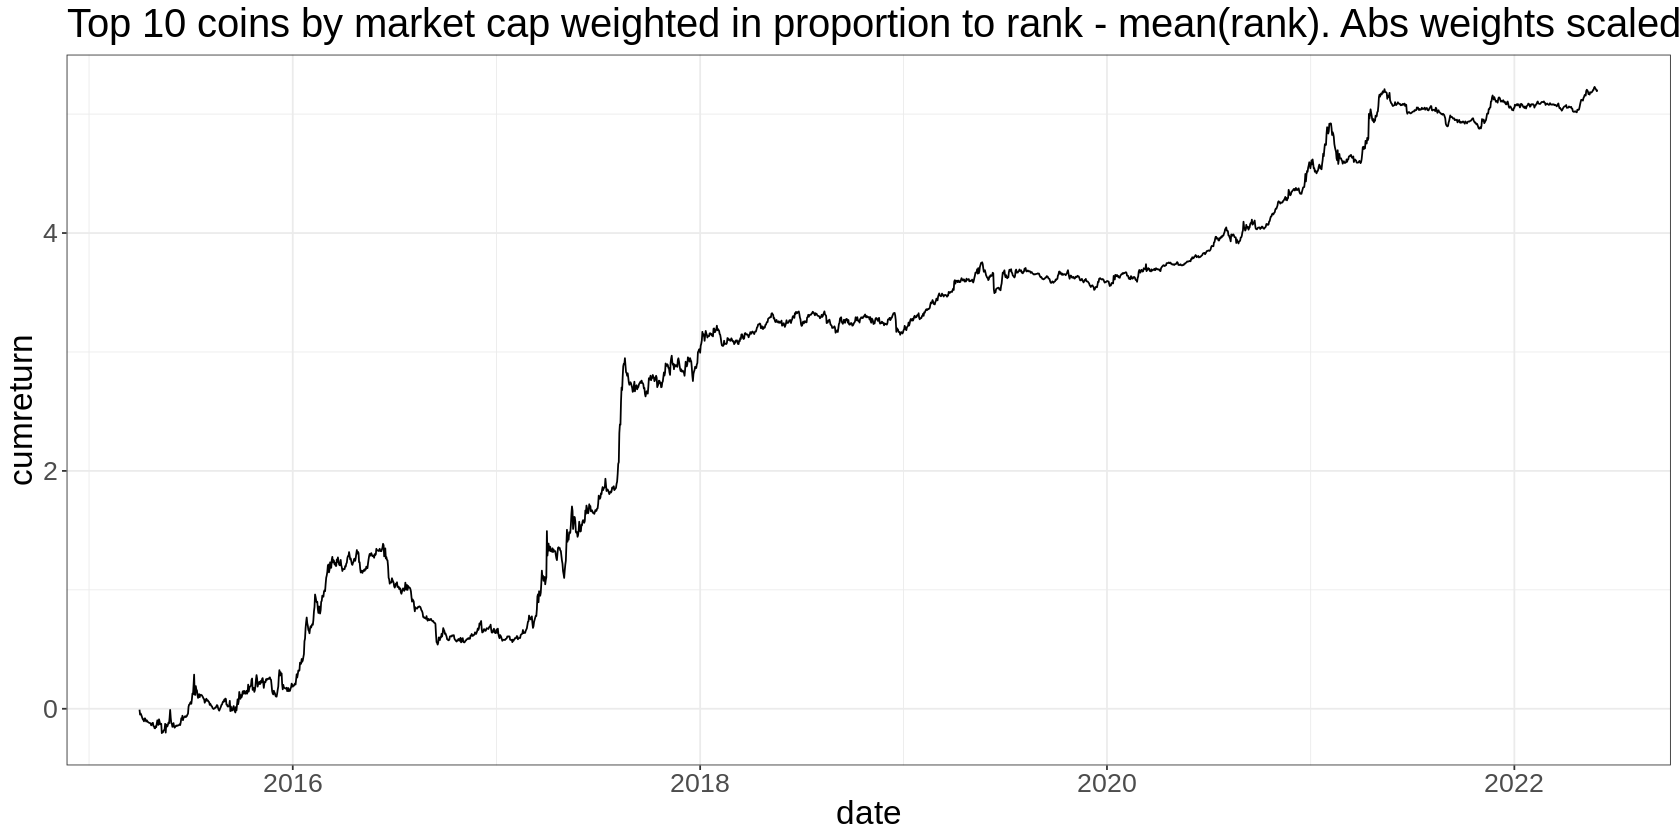

In [16]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    rank = row_number(momo20),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

##3: Weight assets in Proprtion to Momentum ZScore

The zscore of an observation is the number of standard deviations above or below the sample mean that an observation sits.

It's a useful way to standardize how different the observations are.

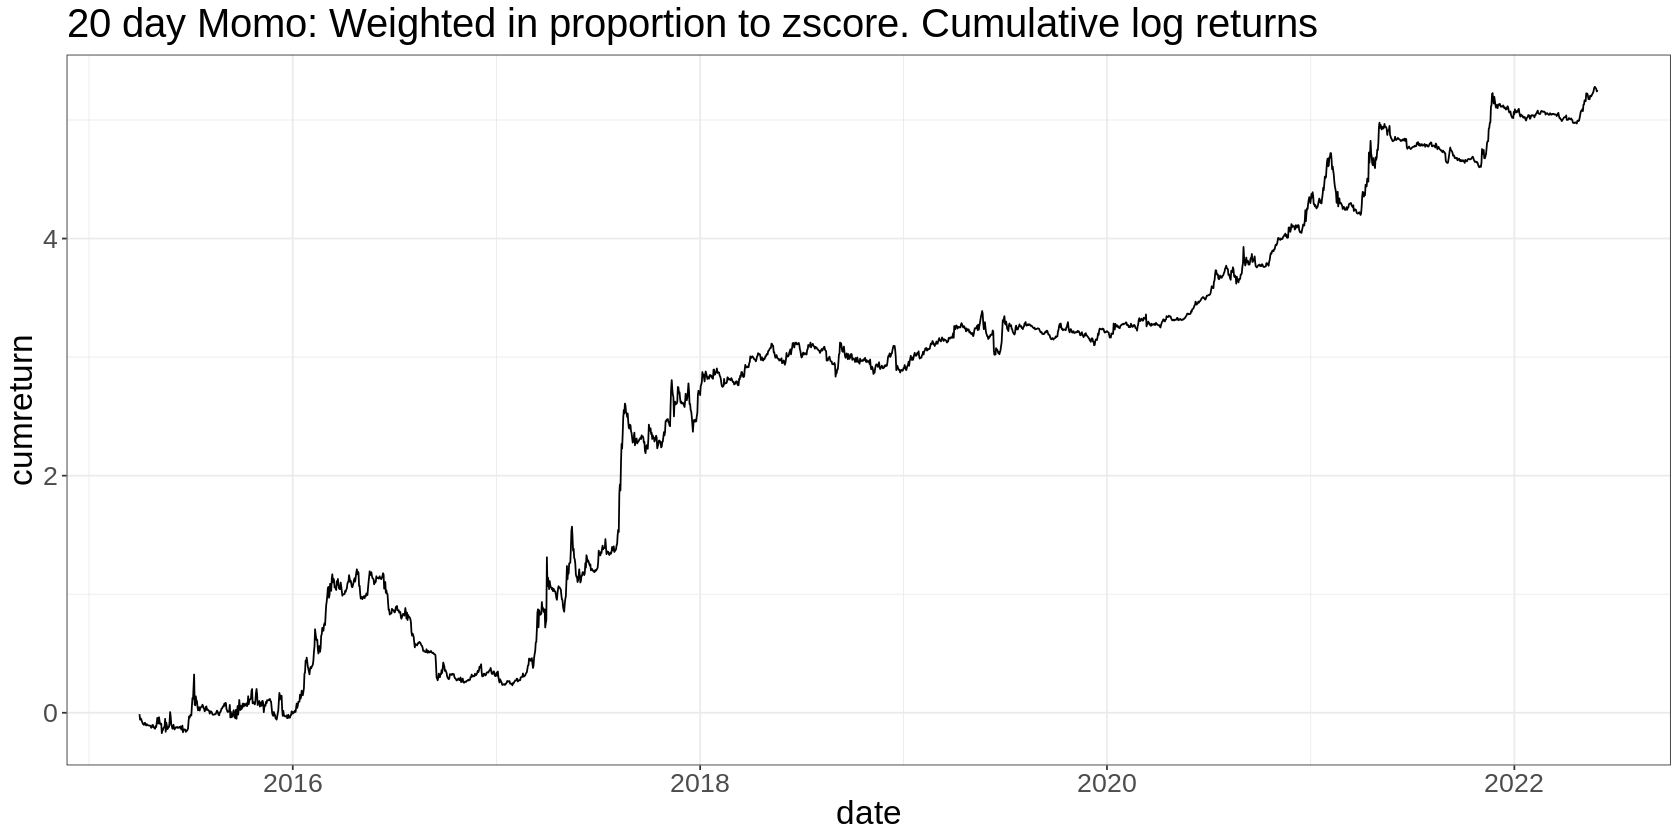

In [17]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    zscore = (momo20 - mean(momo20)) / sd(momo20),
    scaled_weight = zscore / sum(abs(zscore)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Weighted in proportion to zscore. Cumulative log returns')

What if we max zscore out at 2... 



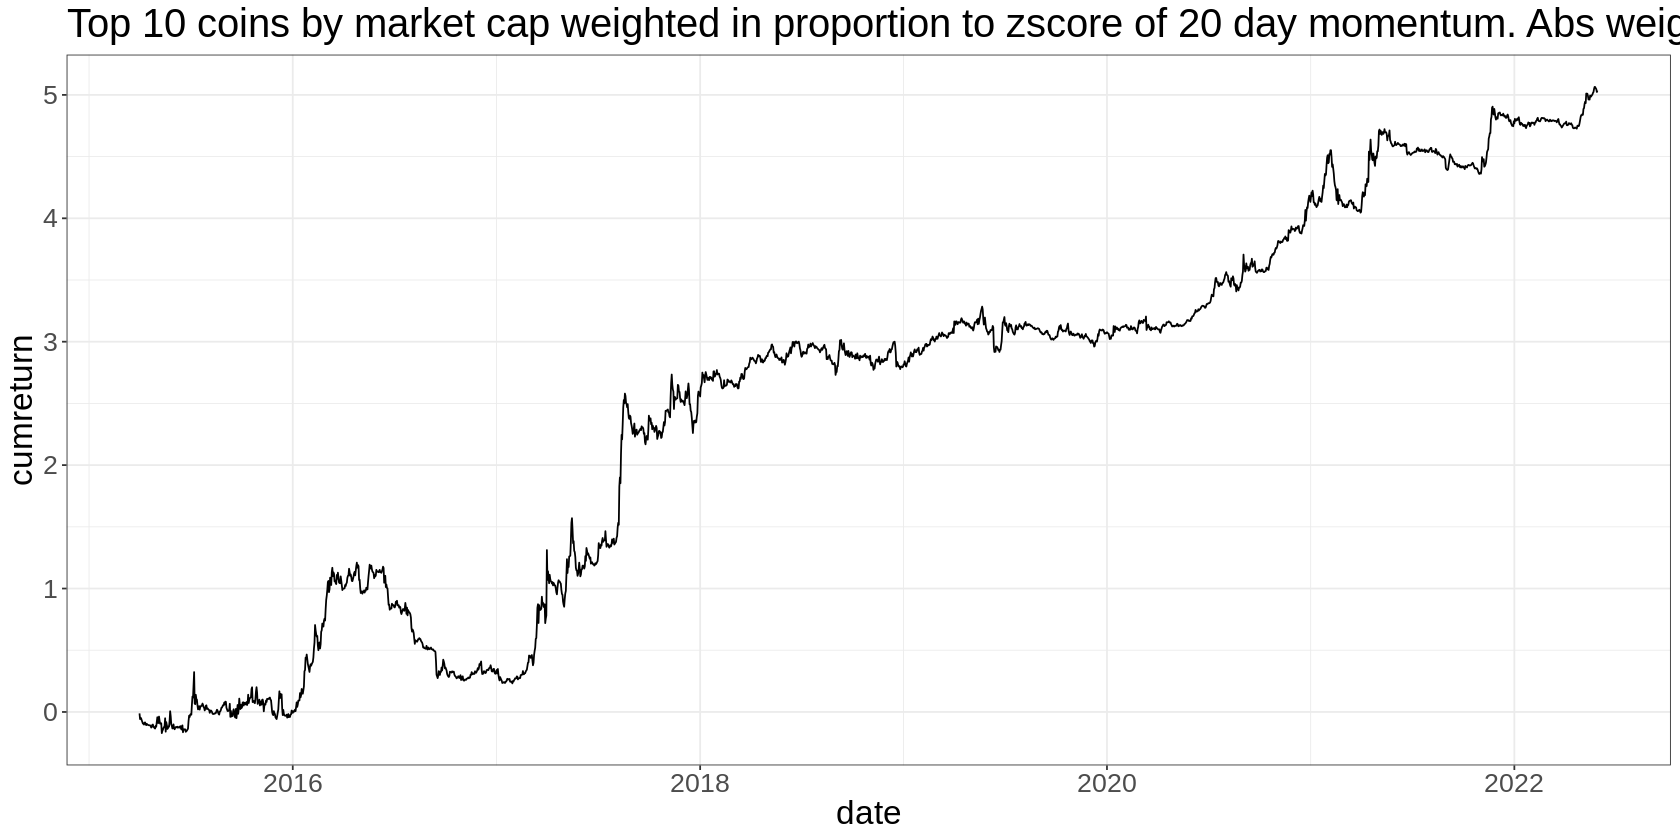

In [18]:
returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(
    zscore = (momo20 - mean(momo20)) / sd(momo20),
    weight = case_when(zscore < -2 ~ -2, zscore > 2 ~ 2, TRUE ~ zscore),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to zscore of 20 day momentum. Abs weights scaled to 1. Cum log returns')

# Analyzing multiple lookbacks of the momentum factor

Let's do the same thing, but with momentum lookbacks of different length.


In [19]:
lookback_returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = price_usd / lag(price_usd, n = 3) - 1,
    "5" = price_usd / lag(price_usd, n = 5) - 1,
    "7" = price_usd / lag(price_usd, n = 7) - 1,
    "10" = price_usd / lag(price_usd, n = 10) - 1,
    "15" = price_usd / lag(price_usd, n = 15) - 1,
    "20" = price_usd / lag(price_usd, n = 20) - 1,
    "30" = price_usd / lag(price_usd, n = 30) - 1,
    "40" = price_usd / lag(price_usd, n = 40) - 1,
    "50" = price_usd / lag(price_usd, n = 50) - 1,
    "60" = price_usd / lag(price_usd, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

lookback_returns %>% tail(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,fwd_log_return,fwd_simple_return,lookback,momo
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,3,0.10832095
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,5,0.08166241
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,7,-0.01910987
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,10,-0.04005198
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,15,0.05640709
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,20,0.10211884
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,30,-0.41241445
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,40,-0.55071989
ZRX,2022-05-31,0.4208294,420829414,22,FALSE,-0.05033243,-0.04908674,50,-0.38433648


`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


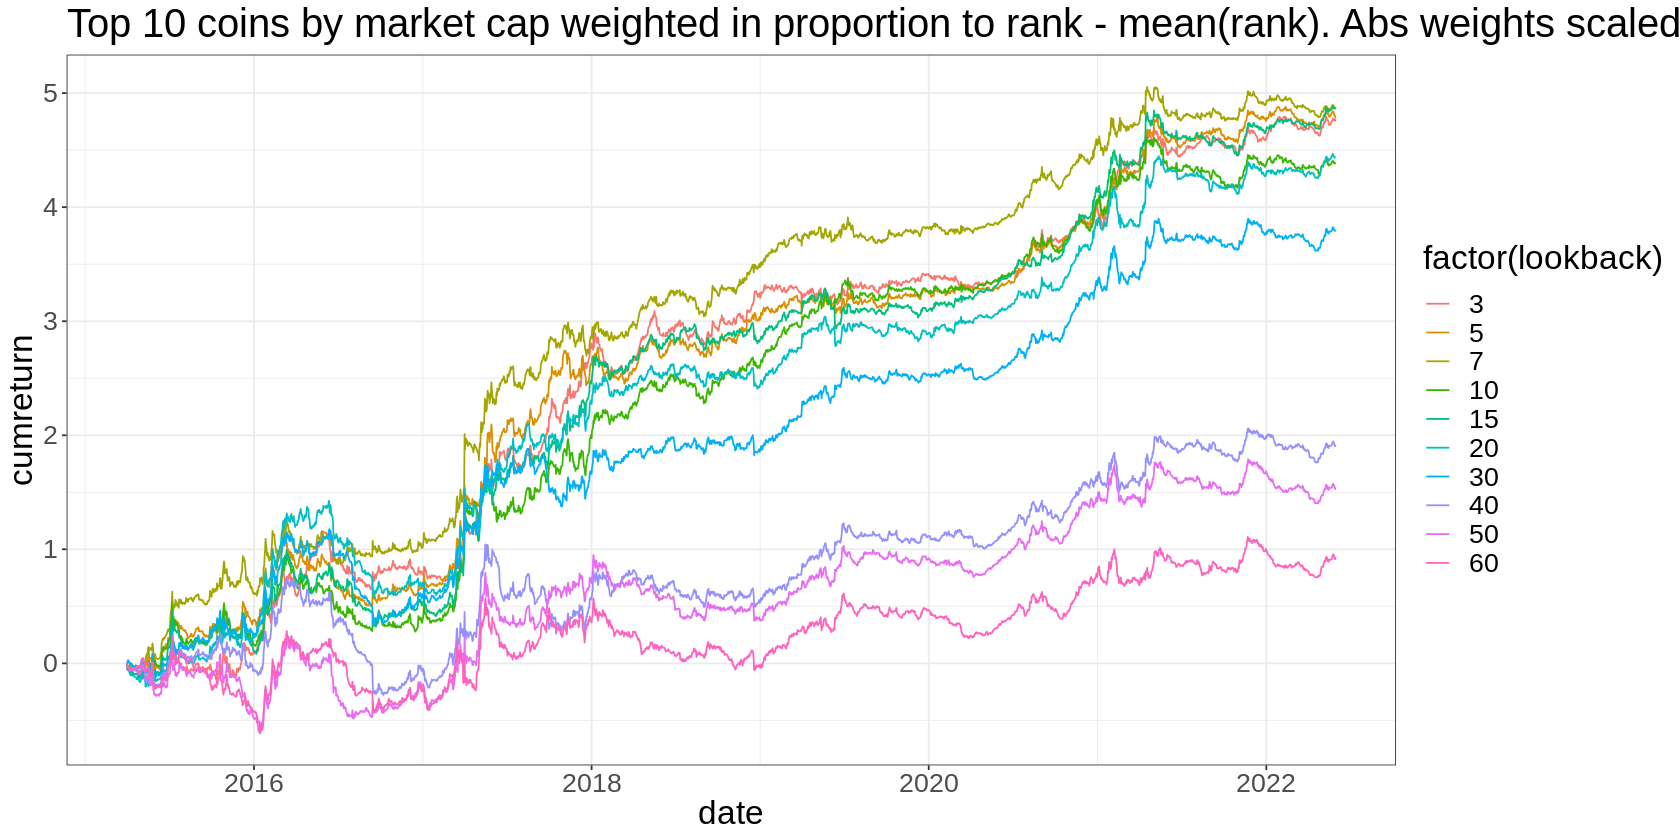

In [20]:
lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

Let's tabulate summary information.


In [21]:
lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / volreturn
  ) %>% 
  arrange(desc(meanreturn))

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
7,0.6799841,0.4923026,1.3812320
15,0.6793939,0.4962597,1.3690288
5,0.6667639,0.5069329,1.3152901
3,0.6624147,0.5063650,1.3081763
20,0.6185489,0.4778938,1.2943230
10,0.6127056,0.4950408,1.2376869
30,0.5301042,0.4761337,1.1133517
40,0.2672786,0.4525726,0.5905761
50,0.2151396,0.4496879,0.4784198


# Alternative Momentum Factors

There is no "correct" way to define momentum - so we'd expect to see a momentum effect however we chose to measure it. 

Here let's look at the difference between current price and a moving average of price.

We follow the same process as before, calculating the factor for a range of lookbacks, constructing factors and tabulating results.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
20,0.7542369,0.4948708,1.5241088
7,0.7366865,0.5084622,1.4488521
15,0.7185117,0.4915418,1.4617508
10,0.7047169,0.5050147,1.3954383
5,0.6816964,0.5156218,1.3220860
30,0.6759585,0.4857619,1.3915427
3,0.6421856,0.5193421,1.2365367
40,0.6200811,0.4811624,1.2887149
50,0.5678190,0.4739076,1.1981641


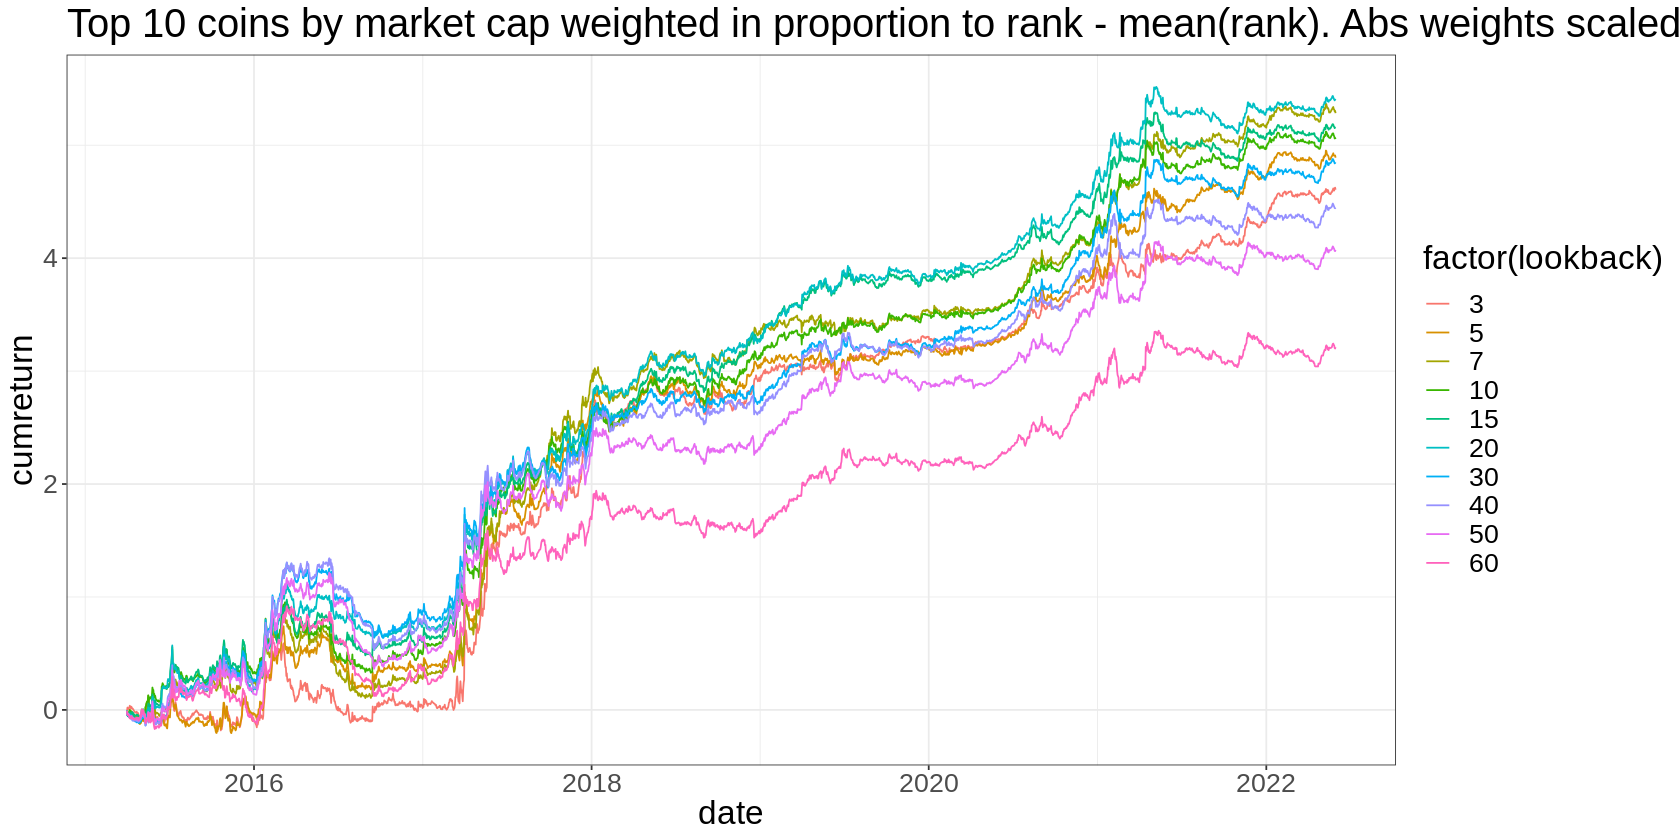

In [22]:
psma_lookback_returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate price to sma feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = price_usd / roll_meanr(price_usd, 3) - 1,
    "5" = price_usd / roll_meanr(price_usd, 5) - 1,
    "7" = price_usd / roll_meanr(price_usd, 7) - 1,
    "10" = price_usd / roll_meanr(price_usd, 10) - 1,
    "15" = price_usd / roll_meanr(price_usd, 15) - 1,
    "20" = price_usd / roll_meanr(price_usd, 20) - 1,
    "30" = price_usd / roll_meanr(price_usd, 30) - 1,
    "40" = price_usd / roll_meanr(price_usd, 40) - 1,
    "50" = price_usd / roll_meanr(price_usd, 50) - 1,
    "60" = price_usd / roll_meanr(price_usd, 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

psma_lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

psma_lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / volreturn
  ) %>% 
  arrange(desc(meanreturn))

This looks similar - if not slightly better than the pure return factor. That may simply because it "effectively" has a shorter lookback.

# 20 Asset Universe

We want these effects to be robust to any reasonable universe. Let's look at 20 asset universe.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
7,0.62292732,0.4874239,1.27799913
15,0.56632358,0.4851616,1.16728846
3,0.52671376,0.5103065,1.03215173
20,0.50760622,0.4734016,1.07225296
10,0.49358167,0.4930176,1.00114410
5,0.49170213,0.5090661,0.96589054
30,0.43822953,0.4650174,0.94239375
40,0.16896893,0.4446771,0.37998119
50,0.11694391,0.4434255,0.26372841


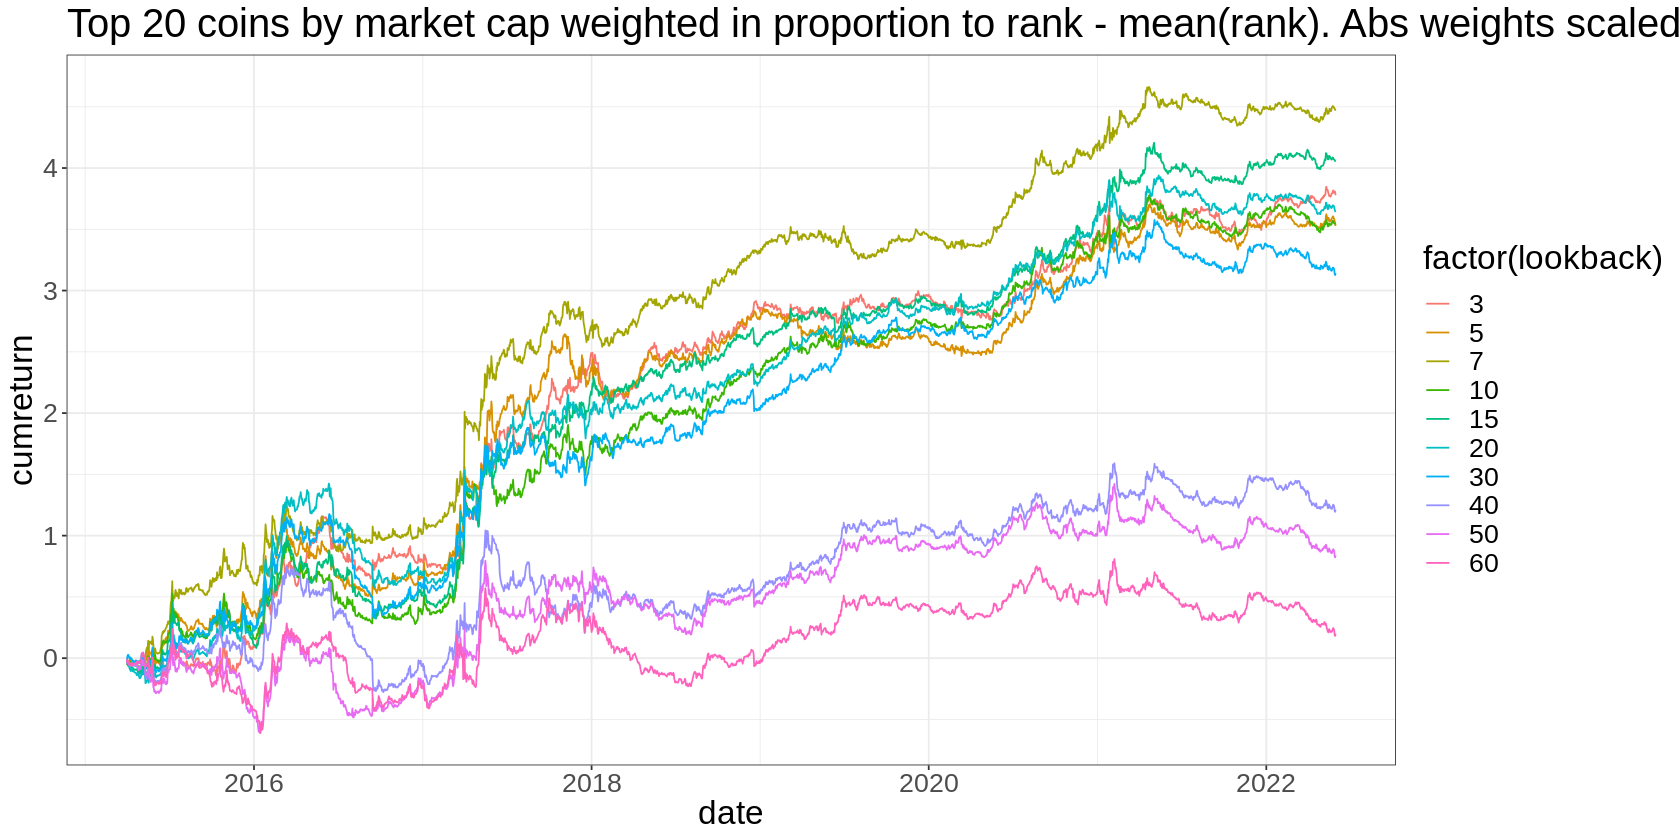

In [23]:
universe20 <- create_universe(prices, n = 20, min_constituents = 20)

lookback_returns20 <- universe20 %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = price_usd / lag(price_usd, n = 3) - 1,
    "5" = price_usd / lag(price_usd, n = 5) - 1,
    "7" = price_usd / lag(price_usd, n = 7) - 1,
    "10" = price_usd / lag(price_usd, n = 10) - 1,
    "15" = price_usd / lag(price_usd, n = 15) - 1,
    "20" = price_usd / lag(price_usd, n = 20) - 1,
    "30" = price_usd / lag(price_usd, n = 30) - 1,
    "40" = price_usd / lag(price_usd, n = 40) - 1,
    "50" = price_usd / lag(price_usd, n = 50) - 1,
    "60" = price_usd / lag(price_usd, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

 lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / volreturn
  ) %>% 
  arrange(desc(meanreturn))

# SMA RATIO


In [24]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate sma310 momentum feature
  mutate( smaratio310 = roll_meanr(price_usd, n = 3) / roll_meanr(price_usd, n = 10)-1,,,
         lagsmaratio310 = lag(smaratio310)) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,smaratio310,lagsmaratio310,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-28,0.05891110,208769.2,1,FALSE,-0.085327032,-0.165002509,0.1710361422,0.1865336321
BTC,2010-07-29,0.06990000,248340.7,1,FALSE,0.005264794,-0.085327032,-0.0779633719,-0.0750016932
BTC,2010-07-30,0.06465738,230303.1,1,FALSE,0.054738094,0.005264794,0.0437035934,0.0446726611
BTC,2010-07-31,0.06754580,241277.0,1,FALSE,0.123208144,0.054738094,-0.1002940046,-0.0954285692
BTC,2010-08-01,0.06110000,218982.4,1,FALSE,0.069610675,0.123208144,-0.0181673040,-0.0180032733
BTC,2010-08-02,0.06000000,215766.0,1,FALSE,0.044868157,0.069610675,0.0002024926,0.0002025132
BTC,2010-08-03,0.06001215,216490.8,1,FALSE,-0.005898172,0.044868157,-0.0512189789,-0.0499293977
BTC,2010-08-04,0.05701578,206374.3,1,FALSE,-0.038567128,-0.005898172,0.0675457882,0.0698792464
BTC,2010-08-05,0.06100000,221460.5,1,FALSE,-0.040949022,-0.038567128,0.0109450481,0.0110051643


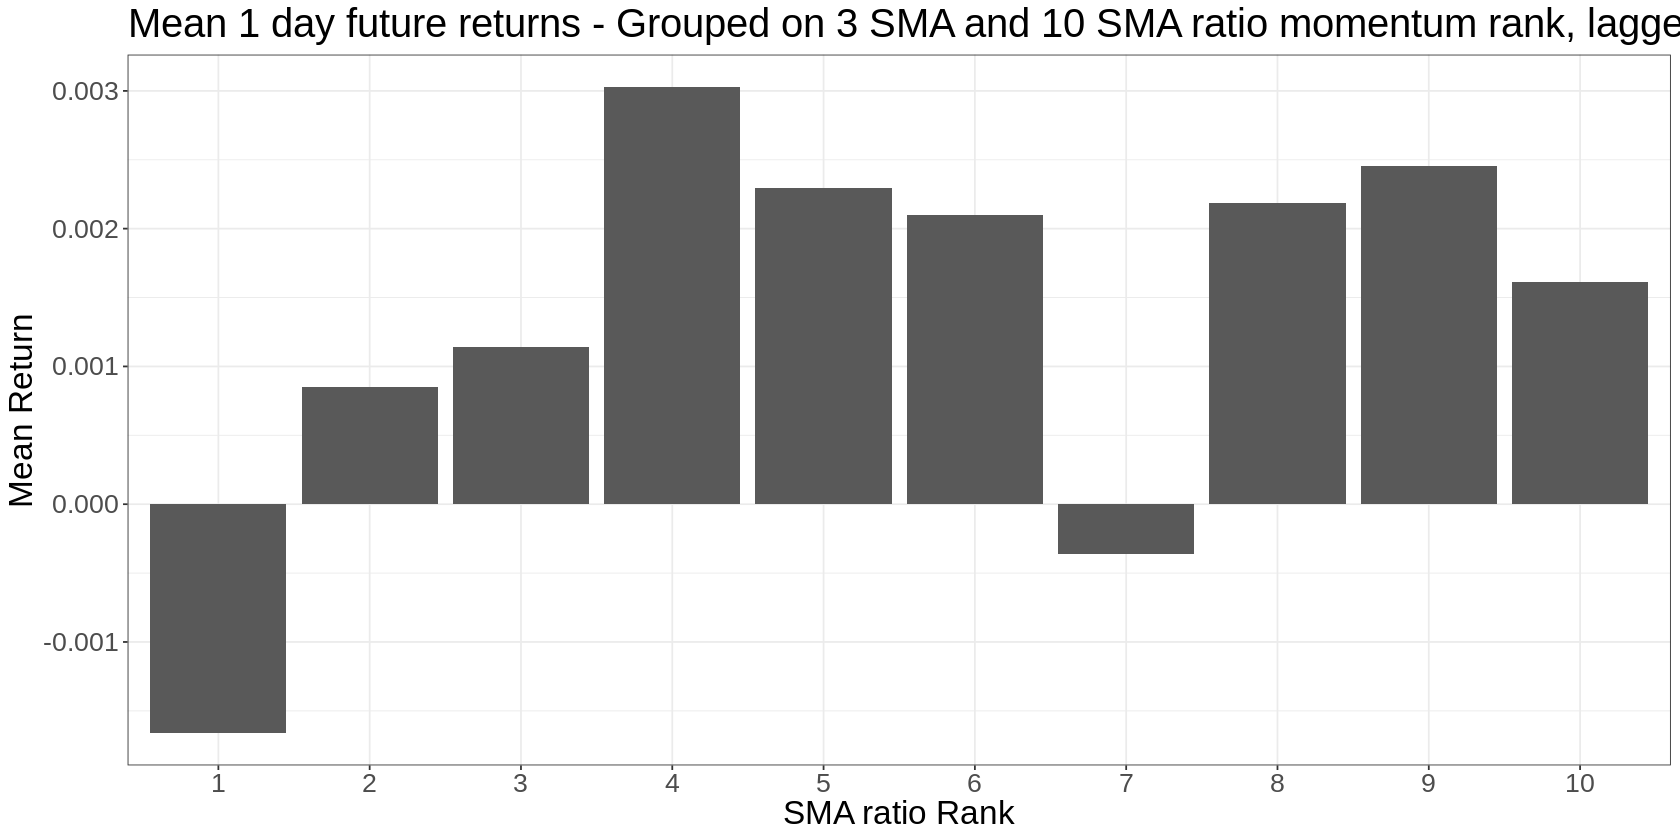

In [25]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(lagrank = factor(row_number(lagsmaratio310))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 3 SMA and 10 SMA ratio momentum rank, lagged 1 day',
    x = 'SMA ratio Rank',
    y = 'Mean Return'
  )

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
520,0.62111520,0.4821329,1.2882655
320,0.61688462,0.4867355,1.2673919
530,0.54898191,0.4730362,1.1605495
330,0.54544927,0.4768120,1.1439504
1030,0.53790208,0.4821682,1.1155901
540,0.46386230,0.4629030,1.0020725
1040,0.45050455,0.4542284,0.9918019
1540,0.39686875,0.4505733,0.8808085
560,0.29305416,0.4569279,0.6413575


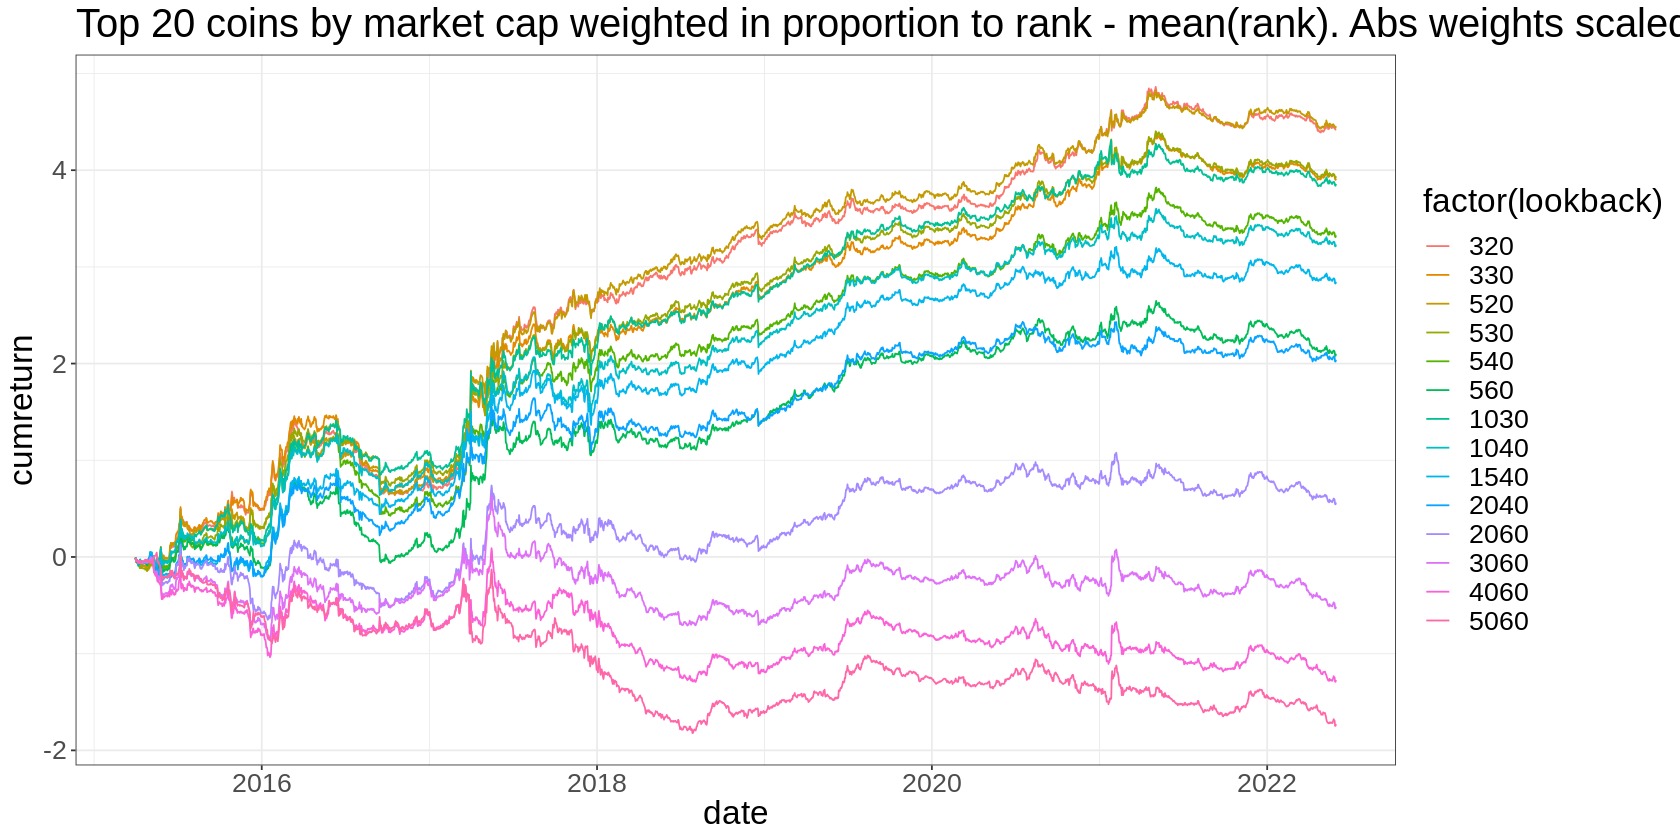

In [26]:
universe20 <- create_universe(prices, n = 20, min_constituents = 20)

lookback_returns20 <- universe20 %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate SMA momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "310" = roll_meanr(price_usd, n = 3) / roll_meanr(price_usd, n = 10)-1,
    "320" = roll_meanr(price_usd, n = 3) / roll_meanr(price_usd, n = 20) - 1,
    "330" = roll_meanr(price_usd, n = 3) / roll_meanr(price_usd, n = 30) - 1,
    "520" = roll_meanr(price_usd, n = 5) / roll_meanr(price_usd, n = 20) - 1,
    "530" = roll_meanr(price_usd, n = 5) / roll_meanr(price_usd, n = 30) - 1,
    "540" = roll_meanr(price_usd, n = 5) / roll_meanr(price_usd, n = 40) - 1,
    "560" = roll_meanr(price_usd, n = 5) / roll_meanr(price_usd, n = 60) - 1,
    "1030" = roll_meanr(price_usd, n = 10) / roll_meanr(price_usd, n = 30) - 1,
    "1040" = roll_meanr(price_usd, n = 10) / roll_meanr(price_usd, n = 40) - 1,
    "1540" = roll_meanr(price_usd, n = 15) / roll_meanr(price_usd, n = 40) - 1,
    "2040" = roll_meanr(price_usd, n = 20) / roll_meanr(price_usd, n = 40) - 1,
    "2060" = roll_meanr(price_usd, n = 20) / roll_meanr(price_usd, n = 60) - 1,
    "3060" = roll_meanr(price_usd, n = 30) / roll_meanr(price_usd, n = 60) - 1,
    "4060" = roll_meanr(price_usd, n = 40) / roll_meanr(price_usd, n = 60) - 1,
    "5060" = roll_meanr(price_usd, n = 50) / roll_meanr(price_usd, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("320":"5060", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

 lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / volreturn
  ) %>% 
  arrange(desc(meanreturn))

Interesting that the slower momentum doesn't perform well at all. Let's check out why

In [27]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate sma5060 momentum feature
  mutate( sma5060 = roll_meanr(price_usd, n = 50) / roll_meanr(price_usd, n = 60) - 1,,
         lagsma5060 = lag(sma5060)) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,sma5060,lagsma5060,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-09-16,0.06190000,248138.5,1,FALSE,0.001422353,-0.005744566,-0.0311668507,-0.0306861711
BTC,2010-09-17,0.06000053,241148.1,1,FALSE,0.003777033,0.001422353,0.0165205352,0.0166577538
BTC,2010-09-18,0.06100000,245888.0,1,FALSE,0.006258832,0.003777033,0.0274875835,0.0278688525
BTC,2010-09-19,0.06270000,253395.8,1,FALSE,0.009118108,0.006258832,-0.0095875070,-0.0095416933
BTC,2010-09-20,0.06210174,251608.3,1,FALSE,0.008465519,0.009118108,0.0087897407,0.0088284839
BTC,2010-09-21,0.06265000,254368.4,1,FALSE,0.008758256,0.008465519,-0.0123364323,-0.0122606504
BTC,2010-09-22,0.06188187,251788.0,1,FALSE,0.007393816,0.008758256,0.0043800848,0.0043896914
BTC,2010-09-23,0.06215351,253620.5,1,FALSE,0.005935805,0.007393816,0.0007476658,0.0007479454
BTC,2010-09-24,0.06220000,254519.3,1,FALSE,0.004673962,0.005935805,-0.0028980861,-0.0028938907


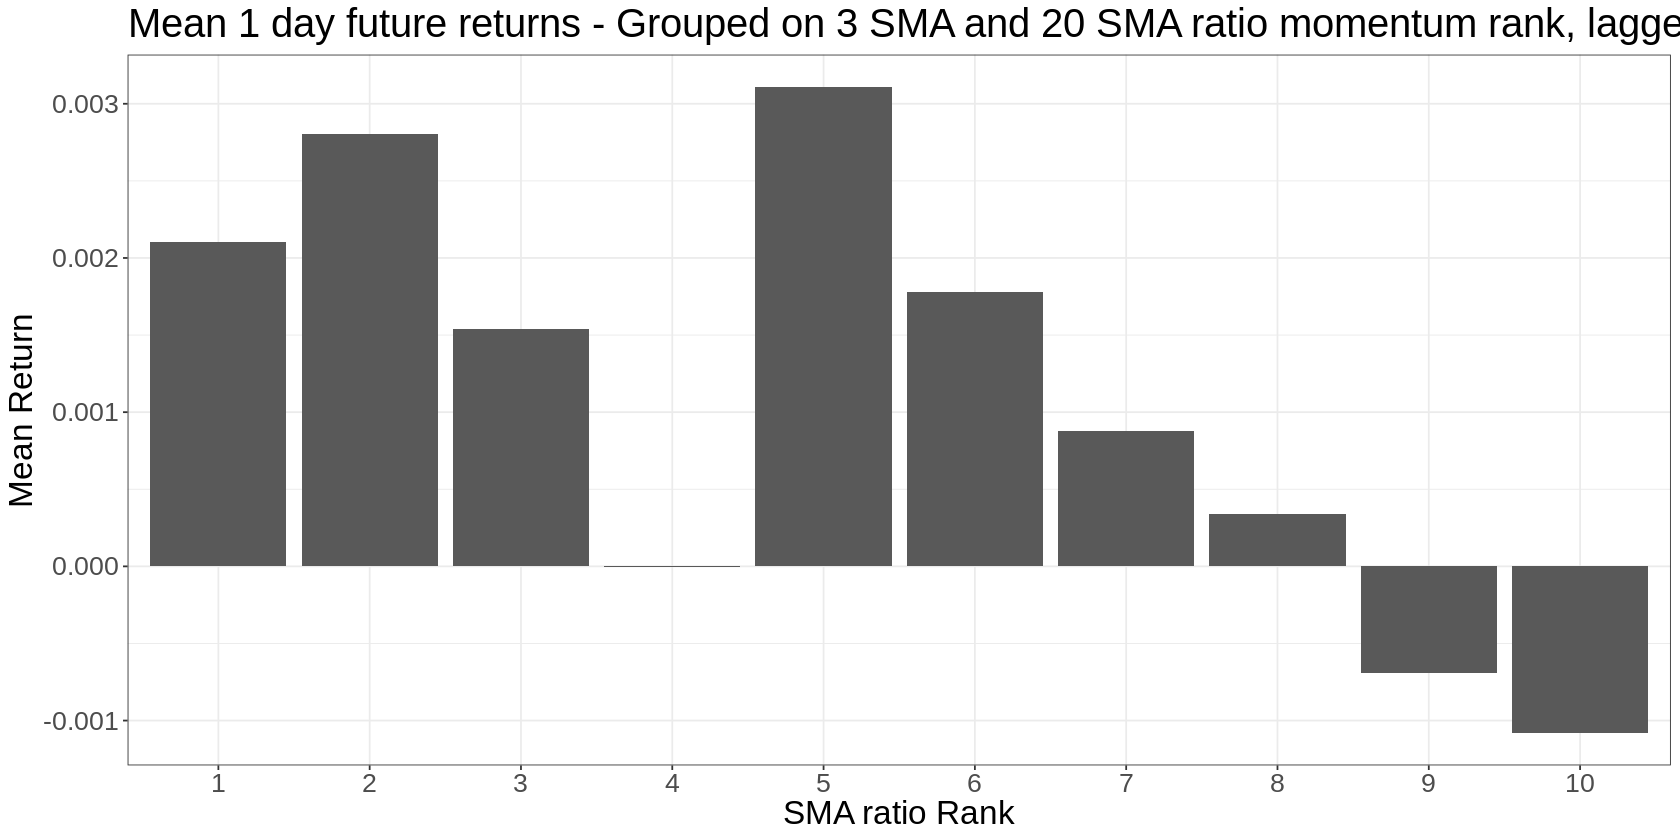

In [28]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(lagrank = factor(row_number(lagsma5060))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on 3 SMA and 20 SMA ratio momentum rank, lagged 1 day',
    x = 'SMA ratio Rank',
    y = 'Mean Return'
  )

#Percentile factor


In [29]:
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate rolling_percentile_50  feature
  mutate( rolling_percentile_50 = roll_percent_rank(price_usd, n = 50) ,
         lagrolling_percentile_50 = lag(rolling_percentile_50)) %>% 
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

ticker,date,price_usd,market_cap,cap_rank,is_index,rolling_percentile_50,lagrolling_percentile_50,fwd_log_return,fwd_simple_return
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-09-06,0.06160000,241589.0,1,FALSE,0.32,0.32,-0.005875701,-0.005858473
BTC,2010-09-07,0.06123912,240663.6,1,FALSE,0.32,0.32,-0.003912305,-0.003904662
BTC,2010-09-08,0.06100000,240227.1,1,FALSE,0.28,0.32,0.001882993,0.001884767
BTC,2010-09-09,0.06111497,241092.4,1,FALSE,0.34,0.28,-0.001694089,-0.001692654
BTC,2010-09-10,0.06101152,241224.3,1,FALSE,0.30,0.34,0.041878714,0.042767998
BTC,2010-09-11,0.06362086,252050.0,1,FALSE,0.48,0.30,-0.033904308,-0.033335997
BTC,2010-09-12,0.06150000,244191.9,1,FALSE,0.34,0.48,0.010996230,0.011056911
BTC,2010-09-13,0.06218000,247423.5,1,FALSE,0.44,0.34,-0.003060323,-0.003055645
BTC,2010-09-14,0.06199000,247296.7,1,FALSE,0.38,0.44,-0.025983977,-0.025649298


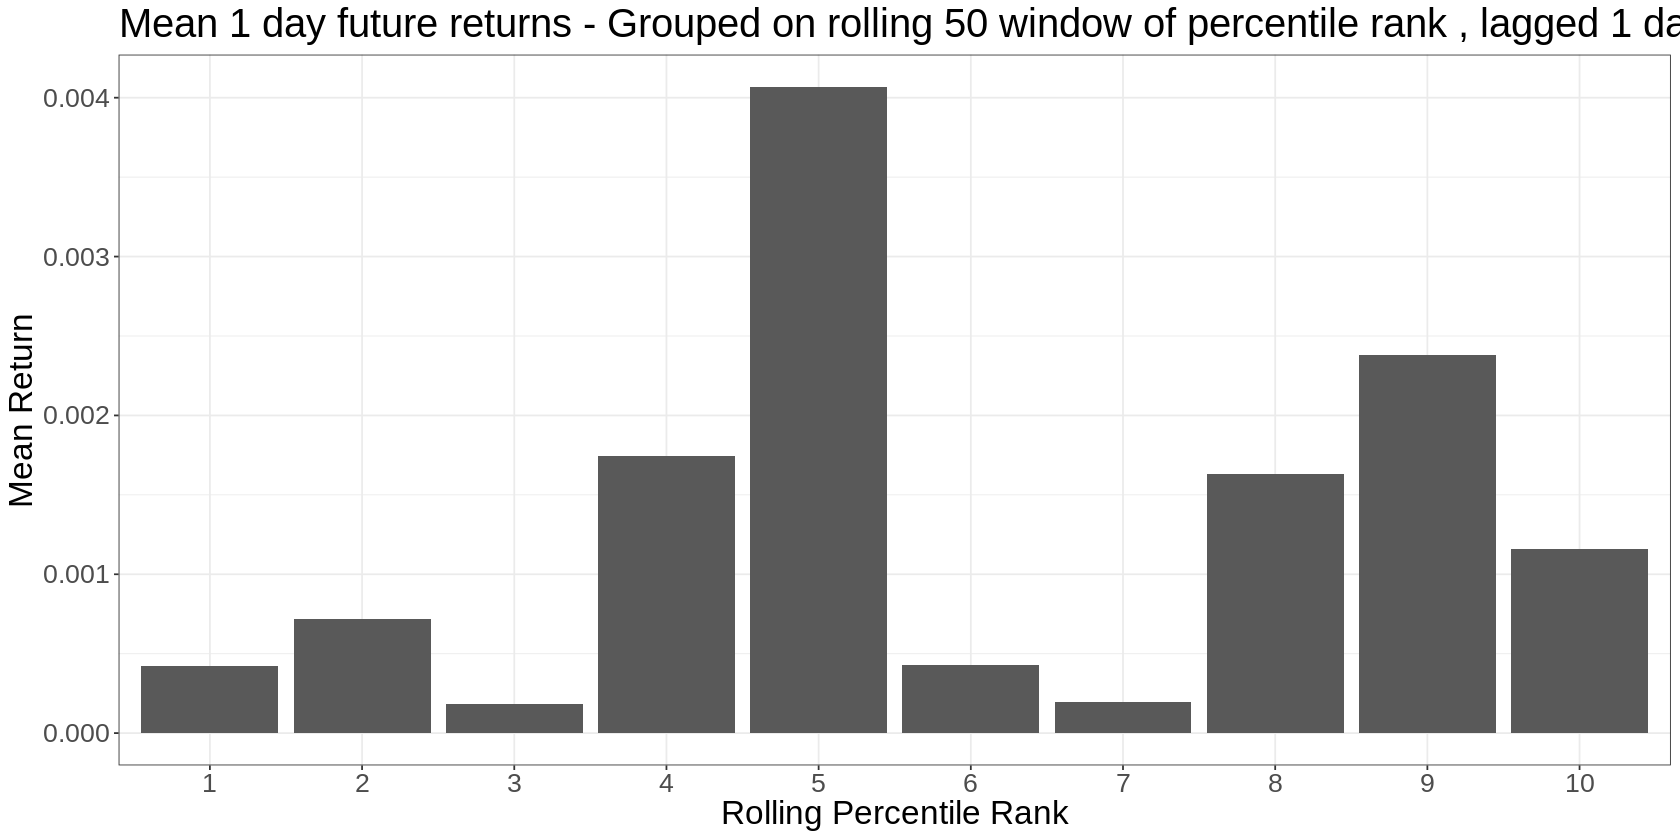

In [30]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(lagrank50 = factor(row_number(lagrolling_percentile_50))) %>%
  group_by(lagrank50) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank50, y=mean_fwd_log_ret)) + 
  geom_bar(stat='identity') + 
  labs(
    title = 'Mean 1 day future returns - Grouped on rolling 50 window of percentile rank , lagged 1 day',
    x = 'Rolling Percentile Rank',
    y = 'Mean Return'
  )

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
20,1.0492740,0.4707870,2.228766
30,0.9774176,0.4717562,2.071870
40,0.9335638,0.4685579,1.992419
10,0.8720738,0.4812739,1.812011
50,0.8393753,0.4653627,1.803701
60,0.8085556,0.4675245,1.729440


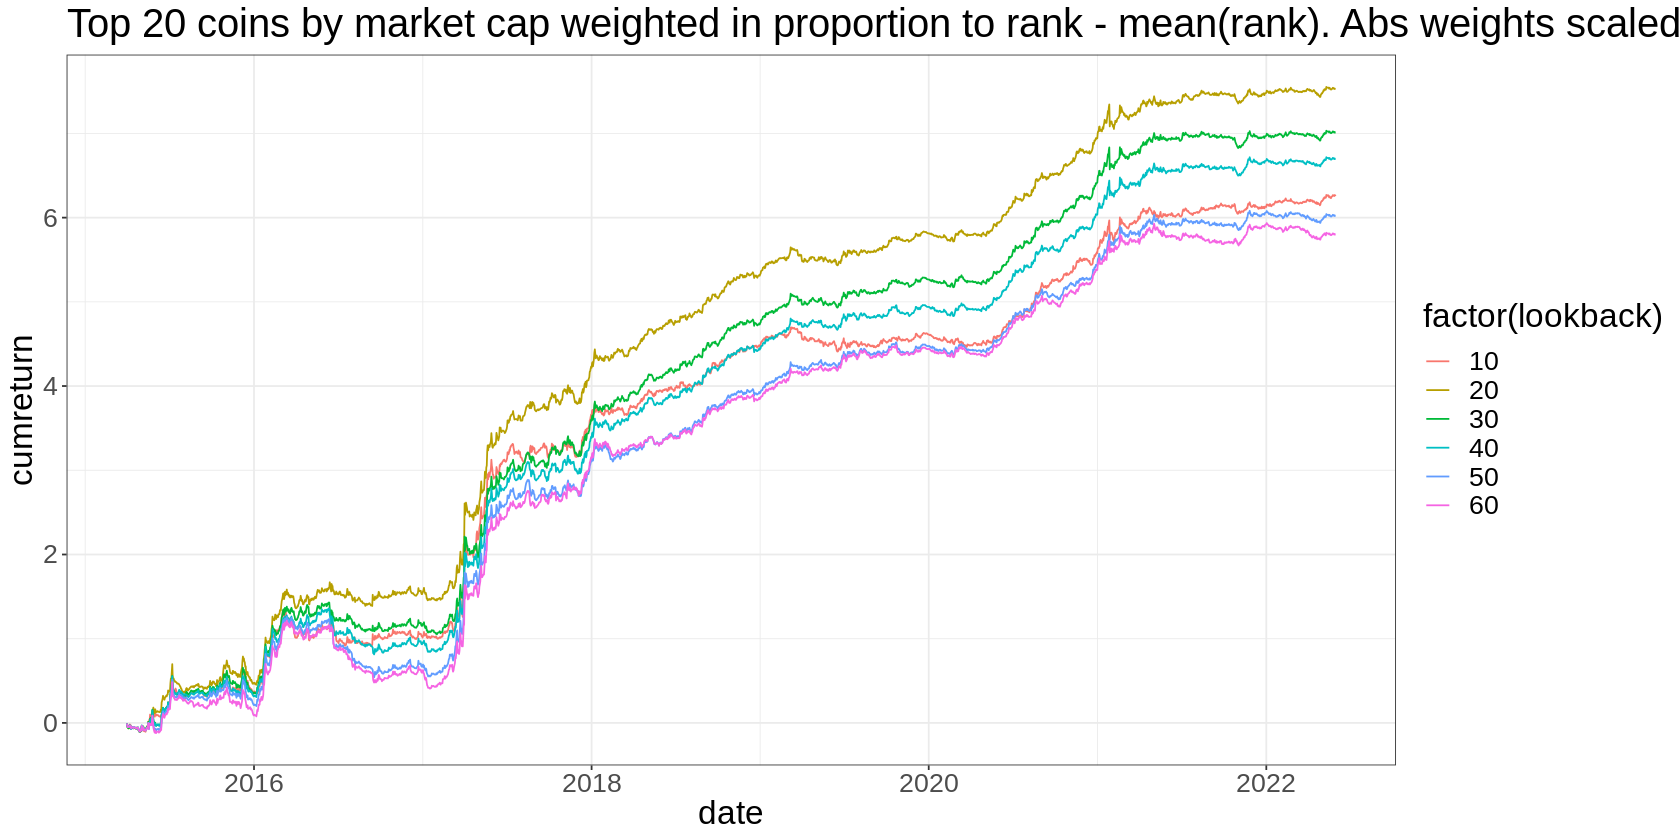

In [31]:
universe20 <- create_universe(prices, n = 20, min_constituents = 20)

lookback_returns20 <- universe20 %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate 20d momentum feature
  mutate(

    # Give columns the name of the lookback for pivoting long to tidy format later
    "10"  = roll_percent_rank(price_usd, n = 10),
    "20"  = roll_percent_rank(price_usd, n = 20),
    "30"  = roll_percent_rank(price_usd, n = 30),
    "40" = roll_percent_rank(price_usd, n = 40),
    "50"  = roll_percent_rank(price_usd, n = 50),
    "60"  = roll_percent_rank(price_usd, n = 60),


  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(price_usd) / price_usd),
         fwd_simple_return = lead(price_usd) / price_usd - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("10":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

 lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / volreturn
  ) %>% 
  arrange(desc(meanreturn))

# Summary

We see a persistent and robust cross-sectional momentum effect. 

It is probably best harnessed with an ensemble of momentum features and parameters.